<a href="https://colab.research.google.com/github/zia207/r-colab/blob/main/NoteBook/Advance_Regression/02-01-03-glm-logistic-r.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](http://drive.google.com/uc?export=view&id=1IFEWet-Aw4DhkkVe1xv_2YYqlvRe9m5_)

# **Logistic Regression Model (Binary Classification)**


This tutorial will focus on implementing a logistic regression model in R, a powerful open-source statistical software that provides numerous functions for easily fitting, interpreting, and visualizing these models. We will begin by reviewing the fundamentals of logistic models, which include understanding their structure, key components, and the types of data they are best suited to handle.

My approach will be step-by-step, starting with constructing a logistic model using synthetic data without relying on any built-in R packages. We will then demonstrate how to fit a logistic model using R's built-in functions (`glm`), interpret the model outputs, per and visualize the results using different R packages.


## Overview

Logistic regression is a statistical method useful in scenarios where the categorical outcome variable has only two possible classes. It is a binary classification method that predicts the probability of an instance belonging to a particular category or class. The method derives its name from its use of the logistic function to model the probability of a given class.

Logistic regression falls under the category of supervised learning. This means that it makes predictions based on labeled data. The method is widely used in various fields, such as finance, healthcare, and marketing. Logistic regression is particularly useful in analyzing datasets with many variables and can be used to identify significant variables that influence the outcome variable.

Despite its name, logistic regression is not used for regression but rather for classification. It is a powerful tool that can help businesses and researchers make informed decisions based on the probability of an event occurring.

Here are the key concepts and components of logistic regression:

1.  **Sigmoid Function (Logistic Function):** The logistic regression model uses the sigmoid function to map any real-valued number into a value between 0 and 1. The sigmoid function is defined as:

$$ \sigma(z) = \frac{1}{1 + e^{-z}} $$

where $z$ is a linear combination of the input features and their corresponding weights.

2.  **Linear Combination:** The linear combination $z$ is given by:

$$ z = b + w_1x_1 + w_2x_2 + \ldots + w_nx_n $$

Here, $b$ is the bias term, $w_i$ are the weights associated with each feature $x_i$, and $n$ is the number of features.

3.  **Probability Prediction:** The output of the logistic regression model is the probability that a given input belongs to a particular class. The sigmoid function ensures that the output is bounded between 0 and 1.

$$ P(Y=1) = \sigma(z) $$ 

$$ P(Y=0) = 1 - \sigma(z) $$

4.  **Decision Boundary:** A decision boundary is a threshold used to classify instances into one of the two classes. If the predicted probability is above the threshold, the instance is assigned to class 1; otherwise, it is assigned to class 0.

5.  **Cost Function (Log Loss):** The logistic regression model is trained by minimizing a cost function, typically the log loss (cross-entropy) function. The goal is to find the set of weights and bias that minimizes the difference between the predicted probabilities and the actual class labels in the training data. Given a set of observations with binary outcomes (0 or 1), the log loss for a single observation is defined as:

$$ J(w,b) = -\frac{1}{m} \sum_{i=1}^{m} [y^{(i)} \log(\hat{y}^{(i)}) + (1 - y^{(i)}) \log(1 - \hat{y}^{(i)})] $$

where $m$ is the number of training examples, $y^{(i)}$ is the true label for the i-th example, and $\hat{y}^{(i)}$ is the predicted probability of class 1 for the i-th example.

Logistic regression is widely used in various fields, including medicine, finance, and social sciences, for binary classification problems. It can be extended to handle multiclass classification through techniques such as one-vs-rest or one-vs-one.



## Building a Logistic Model  from Scratch

In this section, we will demonstrate how to build a logistic regression model in R without using any external packages. We will start by generating synthetic data, then proceed to fit the model, compute summary statistics, and validate the model's performance through k-fold cross-validation. Below are the step-by-step instructions and explanations of the underlying mathematics involved.

In [17]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.stats import norm
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, roc_auc_score


### Generate Synthetic Data

We need to create a dataset with:

-   One binary response variable (contaminated: Yes = 1, No = 0).

-   Four linear predictor variables (we'll call them x1, x2, x3, and x4).

-   One categorical variable with two levels (region: highland or lowland).

In [6]:
import numpy as np
import pandas as pd

# Set seed for reproducibility
np.random.seed(42)

# Sample size
n = 100

# Generate covariates (continuous)
x1 = np.random.normal(loc=0, scale=1, size=n)
x2 = np.random.normal(loc=0, scale=1, size=n)
x3 = np.random.normal(loc=0, scale=1, size=n)
x4 = np.random.normal(loc=0, scale=1, size=n)

# Generate categorical variable 'region'
region = np.random.choice(['highland', 'lowland'], size=n)

# Define true coefficients
beta_0 = -1      # intercept
beta_1 = 0.5
beta_2 = -0.3
beta_3 = 0.2
beta_4 = 0.1
beta_5 = 0.7     # effect of being in "highland" region

# Calculate linear predictor (log-odds)
log_odds = (beta_0 + beta_1 * x1 + beta_2 * x2 + 
            beta_3 * x3 + beta_4 * x4 + 
            beta_5 * (region == 'highland'))

# Convert log-odds to probability using logistic function
probability = np.exp(log_odds) / (1 + np.exp(log_odds))

# Generate binary response variable
contaminated = np.random.binomial(n=1, p=probability, size=n)

# Combine into a DataFrame
data = pd.DataFrame({
    'contaminated': contaminated,
    'x1': x1,
    'x2': x2,
    'x3': x3,
    'x4': x4,
    'region': region
})

# Display first few rows
print(data.head())



   contaminated        x1        x2        x3        x4    region
0             1  0.496714 -1.415371  0.357787 -0.828995  highland
1             1 -0.138264 -0.420645  0.560785 -0.560181  highland
2             1  0.647689 -0.342715  1.083051  0.747294  highland
3             1  1.523030 -0.802277  1.053802  0.610370  highland
4             0 -0.234153 -0.161286 -1.377669 -0.020902   lowland


### Define the Log-Likelihood Function

To fit a logistic regression without using `glm()` or any packages, we need to implement `maximum likelihood estimation (MLE)` from scratch. This involves defining the likelihood function for logistic regression and then using numerical optimization to estimate the coefficients.

Here's how to do it in R:

The probability that an observation $Y_i = 1$ (contaminated = Yes) given predictor variables $X_i$ is given by:

$$ P(Y_i = 1 | X_i) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} + \beta_3 x_{i3} + \beta_4 x_{i4} + \beta_5 \text{region}_i)}} $$

The log-likelihood function for logistic regression, which we want to maximize, is:

$$ \text{log-likelihood} = \sum_{i=1}^n \left( Y_i \cdot \log(P(Y_i = 1 | X_i)) + (1 - Y_i) \cdot \log(1 - P(Y_i = 1 | X_i)) \right) $$

Let's write this in R, where `params` will represent the vector of coefficients $\beta$.

In [7]:
def log_likelihood(params, data):
    # Extract coefficients
    beta_0, beta_1, beta_2, beta_3, beta_4, beta_5 = params
    
    # Calculate linear predictor (log-odds)
    log_odds = (beta_0 + beta_1 * data['x1'] + 
                beta_2 * data['x2'] + 
                beta_3 * data['x3'] + 
                beta_4 * data['x4'] + 
                beta_5 * (data['region'] == 'highland'))
    
    # Logistic transformation: probability
    probability = 1 / (1 + np.exp(-log_odds))
    
    # Avoid log(0) by clipping probabilities
    eps = 1e-15
    probability = np.clip(probability, eps, 1 - eps)
    
    # Log-likelihood
    ll = np.sum(data['contaminated'] * np.log(probability) + 
                (1 - data['contaminated']) * np.log(1 - probability))
    
    return -ll  # Return negative for minimization

### Optimize the Log-Likelihood Function

We use `optim()` to find the parameter values that maximize the likelihood (minimizes the negative log-likelihood).

In [8]:
# Initial guesses for coefficients
initial_params = np.zeros(6)

# Run optimization
result = minimize(log_likelihood, initial_params, args=(data,), method='BFGS', hess=True)

# Extract estimated parameters
estimated_params = result.x
print("Estimated Coefficients:", estimated_params)

/tmp/ipykernel_549228/812670818.py:5: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  result = minimize(log_likelihood, initial_params, args=(data,), method='BFGS', hess=True)


Estimated Coefficients: [-1.72223814  0.56151745 -0.67090996  0.63771895 -0.36066612  1.4468616 ]


### Standard Errors, Z-values, and p-values

In [11]:
# Get Hessian matrix
hessian = result.hess_inv  # Inverse Hessian (BFGS approximation)
# Or use: hessian = result.hess if available

# Variance-covariance matrix
try:
    vcov_matrix = hessian  # For BFGS, hess_inv is already approx. inverse
except:
    vcov_matrix = np.linalg.inv(result.hess)

# Standard errors
standard_errors = np.sqrt(np.diag(vcov_matrix))

# Z-values and p-values
z_values = estimated_params / standard_errors
p_values = 2 * (1 - norm.cdf(np.abs(z_values)))

# Create summary table
summary_table = pd.DataFrame({
    'Coefficient': estimated_params,
    'Std_Error': standard_errors,
    'Z_value': z_values,
    'p_value': p_values
})

print(summary_table)

   Coefficient  Std_Error   Z_value   p_value
0    -1.722238   0.433556 -3.972355  0.000071
1     0.561517   0.306666  1.831041  0.067094
2    -0.670910   0.280882 -2.388579  0.016914
3     0.637719   0.254278  2.507956  0.012143
4    -0.360666   0.294092 -1.226373  0.220058
5     1.446862   0.523692  2.762812  0.005731



### Odds Ratio (OR)

The odds ratio is a measure commonly used in logistic regression, to quantify the strength of association between two events. It represents the odds of an event occurring in one group compared to the odds of it occurring in another group. The odds ratio is calculated as the exponentiated coefficient of a predictor variable.

The odds ratio helps us understand how a one-unit increase in a predictor variable affects the odds of the outcome. Here’s how to interpret it:

-   OR = 1: The predictor does not change the odds of the outcome (no effect).

-   OR \> 1: The predictor increases the odds of the outcome. For instance, if OR = 1.5, a one-unit increase in the predictor increases the odds of the outcome by 50%.

-   OR \< 1: The predictor decreases the odds of the outcome. For example, if OR = 0.7, a one-unit increase in the predictor decreases the odds of the outcome by 30%.

In [12]:
# Exponentiate coefficients (excluding intercept)
odd_ratios = np.exp(estimated_params[1:])  # ORs for x1, x2, x3, x4, region
print("Odds Ratios:", odd_ratios)

Odds Ratios: [1.75333107 0.51124315 1.89215985 0.69721175 4.24975615]


### Model Performance

Evaluating the performance of a logistic regression model involves several metrics and techniques to understand how well the model predicts the outcome variable (e.g., contaminated vs. not contaminated). Here’s a detailed overview of the key evaluation metrics and methods commonly used in this context:

#### Confusion Matrix

A confusion matrix is a simple yet powerful tool for evaluating the performance of a classification model. It provides a summary of prediction results on a classification problem. The confusion matrix summarizes:

-   **True Positives (TP)**: Correctly predicted positive instances.
-   **True Negatives (TN)**: Correctly predicted negative instances.
-   **False Positives (FP)**: Incorrectly predicted positive instances (Type I error).
-   **False Negatives (FN)**: Incorrectly predicted negative instances (Type II error).

**Confusion Matrix Layout**:

|                        | Actual Positive (1) | Actual Negative (0) |
|------------------------|---------------------|---------------------|
| Predicted Positive (1) | TP                  | FP                  |
| Predicted Negative (0) | FN                  | TN                  |


In [13]:
# Compute predicted log-odds and probabilities
log_odds_pred = (estimated_params[0] + 
                 estimated_params[1] * data['x1'] +
                 estimated_params[2] * data['x2'] +
                 estimated_params[3] * data['x3'] +
                 estimated_params[4] * data['x4'] +
                 estimated_params[5] * (data['region'] == 'highland'))

predicted_probabilities = 1 / (1 + np.exp(-log_odds_pred))

# Classify with threshold 0.5
predicted_class = (predicted_probabilities > 0.5).astype(int)
actual_class = data['contaminated'].values

# Confusion Matrix
confusion_matrix = pd.crosstab(predicted_class, actual_class, 
                               rownames=['Predicted'], colnames=['Actual'])
print(confusion_matrix)

# Extract TP, TN, FP, FN
TP = confusion_matrix.loc[1, 1] if (1 in confusion_matrix.index and 1 in confusion_matrix.columns) else 0
TN = confusion_matrix.loc[0, 0] if (0 in confusion_matrix.index and 0 in confusion_matrix.columns) else 0
FP = confusion_matrix.loc[1, 0] if (1 in confusion_matrix.index and 0 in confusion_matrix.columns) else 0
FN = confusion_matrix.loc[0, 1] if (0 in confusion_matrix.index and 1 in confusion_matrix.columns) else 0

Actual      0   1
Predicted        
0          60  14
1           7  19


### Performance Metrics

From the confusion matrix, several performance metrics can be derived:

- ***Accuracy***: The proportion of total correct predictions.
  
  $$   \text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN} $$

- ***Precision*** (Positive Predictive Value): The proportion of predicted positives that are actual positives.
  
  $$   \text{Precision} = \frac{TP}{TP + FP} $$

 - ***Recall*** (Sensitivity or True Positive Rate): The proportion of actual positives that are correctly predicted.
  
  $$ \text{Recall} = \frac{TP}{TP + FN} $$


- ***Specificity*** (True Negative Rate): The proportion of actual negatives that are correctly predicted.
  
  $$   \text{Specificity} = \frac{TN}{TN + FP} $$

- ***F1 Score***: The harmonic mean of precision and recall, useful when dealing with imbalanced classes.
  
  $$ \text{F1 Score} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}} $$

In [14]:
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Specificity: {specificity}")
print(f"F1 Score: {f1_score}")

Accuracy: 0.79
Precision: 0.7307692307692307
Recall: 0.5757575757575758
Specificity: 0.8955223880597015
F1 Score: 0.6440677966101696


#### Receiver Operating Characteristic (ROC) Curve and AUC

The ROC curve is an important tool used in evaluating the performance of a binary classification model. It is a graphical plot that illustrates how well the model can distinguish between positive and negative classes at different threshold settings. The curve displays the trade-off between the true positive rate (sensitivity) and the false positive rate (1 - specificity) as the threshold for classification changes. The true positive rate measures the proportion of actual positive instances that are correctly identified by the model, while the false positive rate measures the proportion of actual negative instances that are incorrectly classified as positive by the model. By analyzing the ROC curve, one can determine the optimal threshold setting that maximizes the true positive rate and minimizes the false positive rate, thereby improving the overall accuracy of the classification model.

-   **True Positive Rate (TPR)**: The y-axis represents the true positive rate (sensitivity).
-   **False Positive Rate (FPR)**: The x-axis represents the false positive rate.

A typical ROC appears as a line that starts at the bottom left corner (0, 0) and extends towards the top right corner (1, 1). If the curve is closer to the top-left corner, it indicates better performance of the model. A diagonal line from (0, 0) to (1, 1) on the ROC curve represents the performance of a random classifier. A model with perfect discrimination will have an ROC curve passing through the top-left corner, indicating a true positive rate of 1 (sensitivity) and a false positive rate of 0 (specificity). The area under the ROC curve (AUC-ROC) is a widely used summary statistic for quantifying the performance of a classification model. AUC-ROC ranges from 0 to 1, with higher values indicating better discrimination. An AUC-ROC of 0.5 suggests that the model performs no better than random guessing, while an AUC-ROC of 1 indicates perfect classification. To summarize, the ROC curve provides a clear visualization of a classification model's performance across different threshold settings. This allows users to select an appropriate threshold based on their specific needs for sensitivity and specificity.

The Area Under the Curve (AUC) quantifies the overall ability of the model to discriminate between the positive and negative classes:

-   **AUC = 1**: Perfect discrimination.
-   **AUC = 0.5**: No discrimination (random guessing).

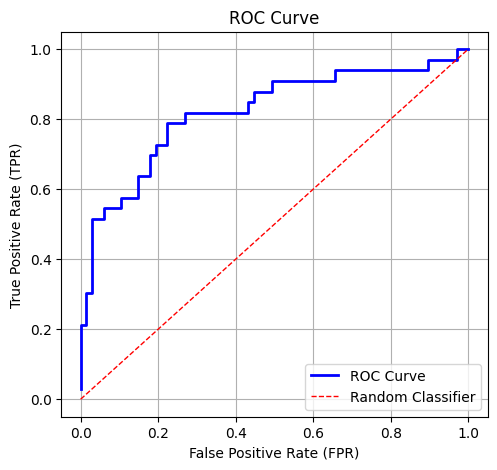

In [19]:
# Sort data by predicted probabilities (descending)
roc_data = pd.DataFrame({'probability': predicted_probabilities, 'actual': actual_class})
roc_data = roc_data.sort_values(by='probability', ascending=False)

# Compute TPR and FPR
TPR = np.cumsum(roc_data['actual']) / np.sum(roc_data['actual'])
FPR = np.cumsum(1 - roc_data['actual']) / np.sum(1 - roc_data['actual'])

# Convert to numpy arrays to avoid pandas indexing issues
FPR = np.array(FPR)
TPR = np.array(TPR)

# Plot ROC Curve
plt.figure(figsize=(5.5, 5))
plt.plot(FPR, TPR, color='blue', lw=2, label='ROC Curve')
plt.plot([0, 1], [0, 1], color='red', lw=1, linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
#plt.text(0.6, 0.2, f'AUC = {AUC:.2f}', color='black', fontsize=12)
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

###  Log-Likelihood and Pseudo-R²

In [20]:
def compute_log_likelihood(params, data):
    beta_0, beta_1, beta_2, beta_3, beta_4, beta_5 = params
    log_odds = (beta_0 + beta_1 * data['x1'] + 
                beta_2 * data['x2'] + 
                beta_3 * data['x3'] + 
                beta_4 * data['x4'] + 
                beta_5 * (data['region'] == 'highland'))
    prob = 1 / (1 + np.exp(-log_odds))
    prob = np.clip(prob, 1e-15, 1 - 1e-15)
    ll = np.sum(data['contaminated'] * np.log(prob) + 
                (1 - data['contaminated']) * np.log(1 - prob))
    return ll

# Full model log-likelihood
ll_full = compute_log_likelihood(estimated_params, data)

# Null model log-likelihood (intercept only)
p_null = data['contaminated'].mean()
ll_null = np.sum(data['contaminated'] * np.log(p_null) + 
                 (1 - data['contaminated']) * np.log(1 - p_null))

# McFadden's Pseudo R²
pseudo_r2 = 1 - (ll_full / ll_null)

print(f"Log-Likelihood of the model: {ll_full}")
print(f"Log-Likelihood of the null model: {ll_null}")
print(f"Pseudo-R²: {pseudo_r2}")

Log-Likelihood of the model: -47.34156366136981
Log-Likelihood of the null model: -63.41786357122056
Pseudo-R²: 0.253497973671038


### k-Fold Cross-Validation

In [21]:
from sklearn.model_selection import KFold

# Set seed for reproducibility
np.random.seed(42)

# Prepare data
X = data[['x1', 'x2', 'x3', 'x4', 'region']].copy()
y = data['contaminated'].copy()

# k-Fold CV
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)
metrics = {
    'accuracy': [], 'precision': [], 'recall': [], 'f1_score': []
}

for train_index, val_index in kf.split(X):
    # Split data
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # Combine into training and validation DataFrames
    train_data = X_train.copy()
    train_data['contaminated'] = y_train.values
    val_data = X_val.copy()
    val_data['contaminated'] = y_val.values
    
    # Fit model on training data
    result_cv = minimize(log_likelihood, initial_params, args=(train_data,), method='BFGS')
    params_cv = result_cv.x
    
    # Predict on validation set
    log_odds_val = (params_cv[0] + 
                    params_cv[1] * val_data['x1'] +
                    params_cv[2] * val_data['x2'] +
                    params_cv[3] * val_data['x3'] +
                    params_cv[4] * val_data['x4'] +
                    params_cv[5] * (val_data['region'] == 'highland'))
    prob_val = 1 / (1 + np.exp(-log_odds_val))
    pred_class = (prob_val > 0.5).astype(int)
    
    # Confusion matrix
    cm = pd.crosstab(pred_class, val_data['contaminated'], rownames=['Pred'], colnames=['Actual'])
    
    TP = cm.loc[1, 1] if (1 in cm.index and 1 in cm.columns) else 0
    TN = cm.loc[0, 0] if (0 in cm.index and 0 in cm.columns) else 0
    FP = cm.loc[1, 0] if (1 in cm.index and 0 in cm.columns) else 0
    FN = cm.loc[0, 1] if (0 in cm.index and 1 in cm.columns) else 0
    
    # Metrics
    acc = (TP + TN) / (TP + TN + FP + FN + 1e-8)
    prec = TP / (TP + FP + 1e-8)
    rec = TP / (TP + FN + 1e-8)
    f1 = 2 * (prec * rec) / (prec + rec + 1e-8)
    
    metrics['accuracy'].append(acc)
    metrics['precision'].append(prec)
    metrics['recall'].append(rec)
    metrics['f1_score'].append(f1)

# Average metrics
avg_metrics = {k: np.mean(v) for k, v in metrics.items()}
print("Cross-Validation Average Metrics:")
for metric, value in avg_metrics.items():
    print(f"Average {metric.capitalize()}: {value:.4f}")

Cross-Validation Average Metrics:
Average Accuracy: 0.7400
Average Precision: 0.6400
Average Recall: 0.5529
Average F1_score: 0.5758


#### Confusion Matrix

A confusion matrix is a simple yet powerful tool for evaluating the performance of a classification model. It provides a summary of prediction results on a classification problem. The confusion matrix summarizes:

- **True Positives (TP)**: Correctly predicted positive instances.
- **True Negatives (TN)**: Correctly predicted negative instances.
- **False Positives (FP)**: Incorrectly predicted positive instances (Type I error).
- **False Negatives (FN)**: Incorrectly predicted negative instances (Type II error).

**Confusion Matrix Layout**:

|               | Actual Positive (1) | Actual Negative (0) |
|---------------|---------------------|---------------------|
| Predicted Positive (1) | TP                  | FP                  |
| Predicted Negative (0) | FN                  | TN                  |

## Logistic Model with Python

The `glm()` function in R is commonly used to fit generalized linear models, including logistic regression. Here’s a guide on how to fit a logistic regression model with `glm()`.

### Data

Our goal is to develop a logistic n model to predict paddy soil arsenic class using various irrigation water and soil properties. We have available data of 263 paired groundwater and paddy soil samples from arsenic contaminated areas in Tala Upazilla, Satkhira district, Bangladesh. This data was utilized in on our publication titled "Factors Affecting Paddy Soil Arsenic Concentration in Bangladesh: Prediction and Uncertainty of Geostatistical Risk Mapping" which can be accessed via the this [URL](https://doi.org/10.1016/j.scitotenv.2011.10.008).

Full data set is available for download from my [Dropbox](https://www.dropbox.com/scl/fo/2rh6r68i9cxmgortvbw8q/h?rlkey=bvntt66n9mcywprmdki08ch3r&dl=0) or from my [Github](https://github.com/zia207/r-colab/tree/main/Data/Regression_analysis) accounts.



In [ ]:
# !pip install pandas numpy matplotlib seaborn plotnine scikit-learn statsmodels patsy

In [22]:
import pandas as pd
import numpy as np

# Load data
url = "https://github.com/zia207/r-colab/raw/main/Data/Regression_analysis/bd_soil_arsenic.csv"
mf = pd.read_csv(url)

# Inspect data
print(mf.head())
print(mf.info())

   ID  Longitude  Latitude    WAs     WP   WFe   WEc   WpH   WMg   WNa  ...  \
0   1    89.1134   22.7544  0.059  0.761  3.44  1.03  7.03  33.9  69.4  ...   
1   2    89.1232   22.7576  0.059  1.194  4.93  1.07  7.06  34.1  74.6  ...   
2   3    89.1281   22.7499  0.079  1.317  9.70  1.40  6.84  40.5  89.4  ...   
3   4    89.1296   22.7568  0.122  1.545  8.58  0.83  6.85  28.4  22.8  ...   
4   5    89.1312   22.7366  0.072  0.966  4.78  1.42  6.95  43.4  93.0  ...   

    SOC     SP  Sand  Silt  Clay  Elevation  Year_Irrigation  Distance_STW  \
0  1.66  13.79  16.3  44.8  38.9          3               14             5   
1  1.26  15.31  11.1  48.7  40.2          5               20             6   
2  1.36  15.54  12.3  46.4  41.3          4               10             5   
3  1.61  16.28  12.7  43.6  43.7          3                8             8   
4  1.26  14.20  12.1  50.9  37.1          5               10             5   

   Land_type  Land_type_ID  
0        MHL             2 

#### Create a Binary Response Variable

The `binary class` typically refers to a classification problem where there are only two possible classes or outcomes. As we see `SAs` is a continuous variable, but we need to convert it into binary class (contaminated and non-contaminated) based on our published paper. The paper suggests that we use the probability of exceeding the upper baseline soil arsenic concentration (14.8 mg/kg) to define soil samples as either As contaminated (`Yes`) or non-contaminated (`No`).

Here we will convert `Soil As (SAs)` into two classes- `Yes = Contaminated`and `No = noncontaminated` and create a new binary response variables (`Class_As`) with two levels:

Yes = `SAs` \> 14.8 mg As/kg

No = `SAs` \< 14.8 mg As/kg

In [23]:
# Create binary class based on SAs > 14.8
mf['Class_As'] = np.where(mf['SAs'] > 14.8, 'Yes', 'No')
mf['Class_As'] = mf['Class_As'].astype('category')

print(mf['Class_As'].value_counts())

Class_As
Yes    170
No      93
Name: count, dtype: int64


#### Box/Violine Plots



/tmp/ipykernel_549228/3708190349.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=mf, x='Class_As', y=col, ax=ax, palette="Set3", width=0.6)
/tmp/ipykernel_549228/3708190349.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=mf, x='Class_As', y=col, ax=ax, palette="Set3", width=0.6)
/tmp/ipykernel_549228/3708190349.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=mf, x='Class_As', y=col, ax=ax, palette="Set3", width=0.6)
/tmp/ipykernel_549228/3708190349.py:26: FutureWarning: 

Passing `palette` without assigning `hue

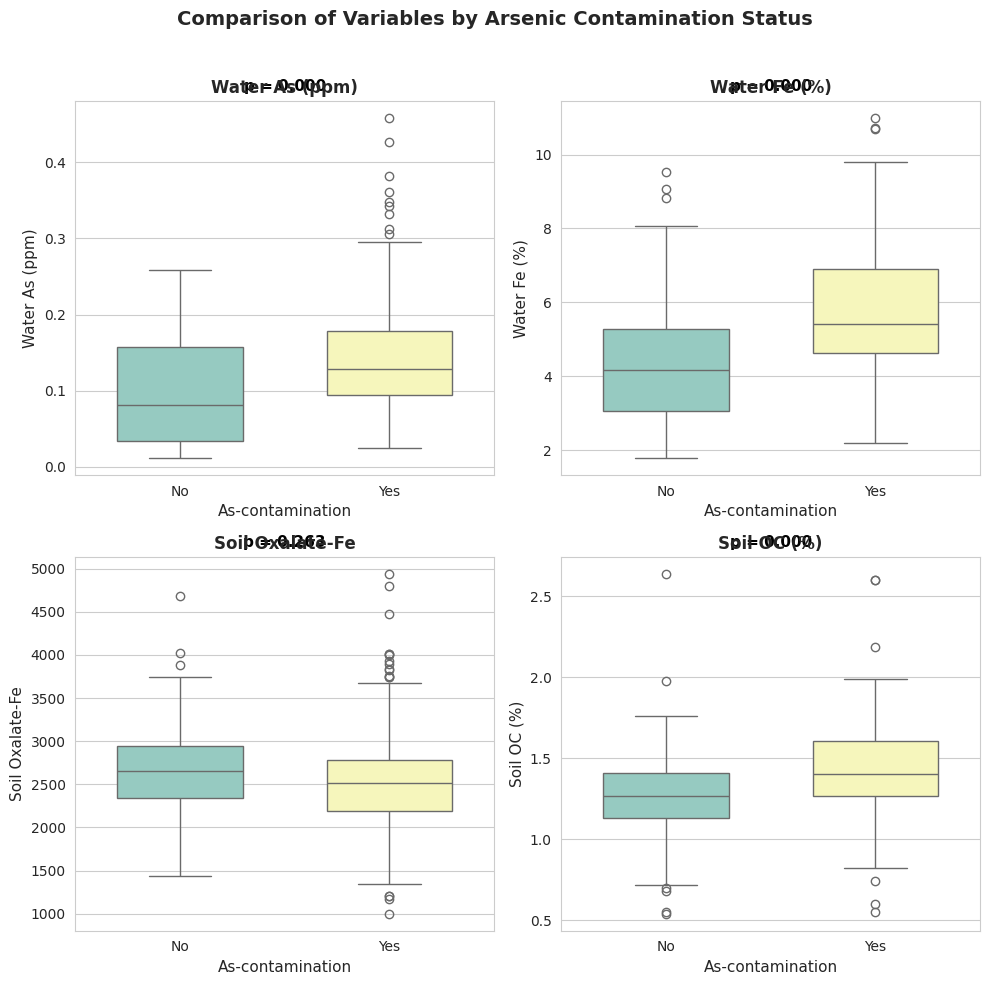

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import numpy as np

# Set style
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 10})

# Variables to plot
variables = [
    ('WAs', 'Water As (ppm)'),
    ('WFe', 'Water Fe (%)'),
    ('SAoFe', 'Soil Oxalate-Fe'),
    ('SOC', 'Soil OC (%)')
]

# Create subplots (2x2)
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.ravel()  # Flatten for easy indexing

for idx, (col, label) in enumerate(variables):
    ax = axes[idx]
    
    # Create boxplot
    sns.boxplot(data=mf, x='Class_As', y=col, ax=ax, palette="Set3", width=0.6)
    
    # Perform independent t-test
    group_yes = mf[mf['Class_As'] == 'Yes'][col].dropna()
    group_no = mf[mf['Class_As'] == 'No'][col].dropna()
    t_stat, p_val = ttest_ind(group_yes, group_no, equal_var=True)
    
    # Add p-value annotation
    y_range = mf[col].max() - mf[col].min()
    y_max = mf[col].max()
    y_pos = y_max + y_range * 0.08  # Slightly above max value
    
    ax.text(0.5, y_pos, f"p = {p_val:.3f}",
            horizontalalignment='center',
            fontsize=11, color='black', weight='bold')

    # Customize labels and title
    ax.set_title(f"{label}", fontsize=12, fontweight='bold')
    ax.set_xlabel("As-contamination", fontsize=11)
    ax.set_ylabel(label, fontsize=11)

# Adjust layout
plt.suptitle("Comparison of Variables by Arsenic Contamination Status",
             fontsize=14, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for suptitle
plt.show()

#### Data Processing


In [25]:
# Select and process variables
df = mf[['WAs', 'WFe', 'SAoFe', 'SOC', 'Year_Irrigation', 'Distance_STW', 'Land_type', 'Class_As']].copy()

# Convert categorical
df['Land_type'] = df['Land_type'].astype('category')
df['Class_As'] = df['Class_As'].astype('category')

# Normalize numerical columns (min-max scaling)
num_cols = ['WAs', 'WFe', 'SAoFe', 'SOC', 'Year_Irrigation', 'Distance_STW']
for col in num_cols:
    col_min = df[col].min()
    col_max = df[col].max()
    df[col] = (df[col] - col_min) / (col_max - col_min)

print(df.head())


        WAs       WFe     SAoFe       SOC  Year_Irrigation  Distance_STW  \
0  0.107383  0.180435  0.380711  0.533333         0.684211      0.047619   
1  0.107383  0.342391  0.423858  0.342857         1.000000      0.071429   
2  0.152125  0.860870  0.294416  0.390476         0.473684      0.047619   
3  0.248322  0.739130  0.380711  0.509524         0.368421      0.119048   
4  0.136465  0.326087  0.269036  0.342857         0.473684      0.047619   

  Land_type Class_As  
0       MHL      Yes  
1       MHL      Yes  
2       MHL      Yes  
3       MHL      Yes  
4       MHL      Yes  


#### Split Data

We will use the `ddply()` function of the **plyr** package to split soil carbon datainto homogeneous subgroups using **stratified random sampling**. This method involves dividing the population into strata and taking random samples from each stratum to ensure that each subgroup is proportionally represented in the sample. The goal is to obtain a representative sample of the population by adequately representing each stratum.


In [26]:
from sklearn.model_selection import train_test_split

# Set seed
np.random.seed(101)

# Stratified split by Land_type and Class_As
df['strata'] = df['Land_type'].astype(str) + "_" + df['Class_As'].astype(str)

train, test = train_test_split(
    df, 
    test_size=0.3, 
    stratify=df['strata'], 
    random_state=101
)

# Drop helper column
train = train.drop(columns=['strata'])
test = test.drop(columns=['strata'])

# Check proportions
print("Train Class_As proportion:")
print(train['Class_As'].value_counts(normalize=True))
print("\nTest Class_As proportion:")
print(test['Class_As'].value_counts(normalize=True))

Train Class_As proportion:
Class_As
Yes    0.646739
No     0.353261
Name: proportion, dtype: float64

Test Class_As proportion:
Class_As
Yes    0.64557
No     0.35443
Name: proportion, dtype: float64


Stratified random sampling is a technique for selecting a representative sample from a population, where the sample is chosen in a way that ensures that certain subgroups within the population are adequately represented in the sample.

In [ ]:
%%R
print(prop.table(table(train$Class_As)))
print(prop.table(table(test$Class_As)))


       No       Yes 
0.3551913 0.6448087 

  No  Yes 
0.35 0.65 


### Fit a Logistic Model



In [27]:
import statsmodels.api as sm
import patsy

# Prepare design matrix
formula = "C(Class_As, Treatment('No')) ~ WAs + WFe + SAoFe + SOC + Year_Irrigation + Distance_STW + C(Land_type)"
y_train, X_train = patsy.dmatrices(formula, train, return_type='dataframe')

# Fit model
model = sm.GLM(y_train, X_train, family=sm.families.Binomial()).fit()

print(model.summary())

                                             Generalized Linear Model Regression Results                                             
Dep. Variable:     ["C(Class_As, Treatment('No'))[No]", "C(Class_As, Treatment('No'))[Yes]"]   No. Observations:                  184
Model:                                                                                   GLM   Df Residuals:                      176
Model Family:                                                                       Binomial   Df Model:                            7
Link Function:                                                                         Logit   Scale:                          1.0000
Method:                                                                                 IRLS   Log-Likelihood:                -78.597
Date:                                                                       Fri, 08 Aug 2025   Deviance:                       157.19
Time:                                                         

### Interpretation of Logistic Model



In [28]:
# Odds Ratios
odds_ratios = np.exp(model.params)
conf_int = np.exp(model.conf_int())
conf_int.columns = ['OR_Lower', 'OR_Upper']
conf_int['OR'] = odds_ratios
print(conf_int)

                     OR_Lower    OR_Upper         OR
Intercept            2.284577   96.494351  14.847518
C(Land_type)[T.MHL]  0.122012    0.699115   0.292062
WAs                  0.000565    0.163321   0.009604
WFe                  0.003923    0.270068   0.032551
SAoFe                0.144808   21.925406   1.781848
SOC                  0.052225   23.809922   1.115107
Year_Irrigation      0.002629    0.173501   0.021356
Distance_STW         1.293880  624.562464  28.427257


### Model Performance

In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss, confusion_matrix
from scipy.stats import bernoulli

# Predict on test set
X_test = patsy.dmatrix(formula.split('~')[1], test, return_type='dataframe')
pred_prob = model.predict(X_test)
pred_class = (pred_prob > 0.5).astype(int)
true_class = (test['Class_As'] == 'Yes').astype(int)

# Performance
accuracy = accuracy_score(true_class, pred_class)
precision = precision_score(true_class, pred_class)
recall = recall_score(true_class, pred_class)
f1 = f1_score(true_class, pred_class)
auc = roc_auc_score(true_class, pred_prob)
logloss = log_loss(true_class, pred_prob)

# Tjur's R²
tjur_r2 = np.mean(pred_prob[true_class == 1]) - np.mean(pred_prob[true_class == 0])

print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"AUC: {auc:.3f}")
print(f"Log Loss: {logloss:.3f}")
print(f"Tjur's R²: {tjur_r2:.3f}")

Accuracy: 0.215
Precision: 0.296
Recall: 0.157
F1 Score: 0.205
AUC: 0.154
Log Loss: 1.790
Tjur's R²: -0.383


**`Tjur's R²`**, also known as Tjur's coefficient of discrimination, is a measure of discrimination or predictive accuracy for binary outcomes in logistic regression. It assesses how well the model distinguishes between the two categories of the dependent variable. Tjur's R² is defined as the difference in the average predicted probabilities of the two outcomes.

The formula for Tjur's R² is as follows:

$$ R^2_{Tjur} = P(Y=1|\hat{Y}=1) - P(Y=0|\hat{Y}=1) $$

Here:

-   $P(Y=1|\hat{Y}=1)$ is the probability of the actual outcome being 1 given that the predicted outcome is 1.

-   $P(Y=0|\hat{Y}=1)$ is the probability of the actual outcome being 0 given that the predicted outcome is 1.

Tjur's R² ranges from -1 to 1, where a higher value indicates better discrimination. A positive value suggests that the model is better at predicting the positive class, while a negative value suggests better prediction for the negative class.

In practice, Tjur's R² is not as commonly used as other metrics like the area under the ROC curve (AUC) or the Brier score, but it provides a measure of the practical significance of the logistic regression model in terms of discrimination. Keep in mind that the interpretation of Tjur's R² should be done in the context of the specific dataset and problem you are working on.

**`Log_loss`**: Logarithmic Loss (Log Loss), also known as cross-entropy loss, is a commonly utilized loss function in machine learning, particularly in classification problems. It measures the performance of a classification model that outputs a probability value ranging from 0 to 1. Due to its versatility and capability to handle prediction errors, Logarithmic Loss is often preferred over alternative loss functions. Its formulation is mathematically rigorous, and its implementation is straightforward, making it an essential tool for any machine learning practitioner.

The formula for Log Loss is:

$$ {Log Loss} = -\frac{1}{N} \sum_{i=1}^{N} [y_i \log(p_i) + (1 - y_i) \log(1 - p_i)] $$

Where:

\- $N$ is the number of samples in the dataset.

\- $y_i$ is the true label for the $i$ th sample (0 or 1 for binary classification, or one-hot encoded vectors for multiclass classification).

-   $p_i$ is the predicted probability that the $i$ th sample belongs to the positive class.



### Prediction and Evaluation

In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss, confusion_matrix
from scipy.stats import bernoulli

# Predict on test set
X_test = patsy.dmatrix(formula.split('~')[1], test, return_type='dataframe')
pred_prob = model.predict(X_test)
pred_class = (pred_prob > 0.5).astype(int)
true_class = (test['Class_As'] == 'Yes').astype(int)

# Performance
accuracy = accuracy_score(true_class, pred_class)
precision = precision_score(true_class, pred_class)
recall = recall_score(true_class, pred_class)
f1 = f1_score(true_class, pred_class)
auc = roc_auc_score(true_class, pred_prob)
logloss = log_loss(true_class, pred_prob)

# Tjur's R²
tjur_r2 = np.mean(pred_prob[true_class == 1]) - np.mean(pred_prob[true_class == 0])

print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"AUC: {auc:.3f}")
print(f"Log Loss: {logloss:.3f}")
print(f"Tjur's R²: {tjur_r2:.3f}")

Accuracy: 0.215
Precision: 0.296
Recall: 0.157
F1 Score: 0.205
AUC: 0.154
Log Loss: 1.790
Tjur's R²: -0.383


### ROC Curve

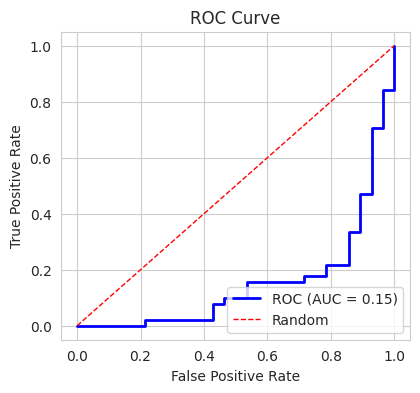

In [32]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(true_class, pred_prob)
auc_score = roc_auc_score(true_class, pred_prob)

plt.figure(figsize=(4.5, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=1, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

### The Logistic Distribution of Intercept and Slopes

The `plogis()` function is used to calculate the logistic cumulative distribution function (CDF) of Intercept and Slopes. The logistic CDF is the probability that a logistic random variable is less than or equal to a specified value. The `plogis()` function takes a numeric vector of values and returns the corresponding probabilities.

The `plogis()` function is particularly useful in the context of logistic regression, where you might be interested in converting log-odds into probabilities. If you have a logistic regression model with coefficients (intercept and slopes), you can use the logistic function and `plogis` to calculate probabilities.

In [ ]:
%%R
## Intercept
intercept = coef(fit.logit)[1]
# Back-transform the  Slope of WAs
slop_was = coef(fit.logit)[2]
log_odds<-intercept + (slop_was*train$WAs)
probabilities <- plogis(log_odds)
age.prob<-data.frame(WAs = train$WAs, LogOdds = log_odds, Probability = probabilities) |>
  glimpse()

Rows: 183
Columns: 3
$ WAs         <dbl> 0.019, 0.043, 0.037, 0.126, 0.019, 0.020, 0.207, 0.016, 0.…
$ LogOdds     <dbl> -5.830588, -5.527392, -5.603191, -4.478839, -5.830588, -5.…
$ Probability <dbl> 0.002927753, 0.003960598, 0.003672546, 0.011219281, 0.0029…


### Marginal Effects and Adjusted Predictions

The presentation of regression models, typically in the form of tables, is widely accepted as a clear and accessible method for interpreting results. However, for more intricate models that incorporate interaction or transformed terms, such as quadratic or spline terms, the use of raw regression coefficients may prove less effective, resulting in challenges when interpreting outcomes. In such cases, adjusted predictions or marginal means provide a more fitting solution. The use of visual aids can also assist in the comprehension of such effects or predictions, providing an intuitive understanding of the relationship between predictors and outcomes, even for complex models.

If we want the marginal effects for "Land_types", you may use `margins()` function of {margins} package:

In [ ]:
%%R
margins::margins(fit.logit, variables = "WAs")

  WAs
 1.57


we get the same marginal effect using `avg_slopes()` function from the {marginaleffects} package

In [ ]:
%%R
marginaleffects::avg_slopes(fit.logit, variables = "WAs")


 Estimate Std. Error    z Pr(>|z|)    S 2.5 % 97.5 %
     1.57      0.396 3.96   <0.001 13.7 0.794   2.35

Term: WAs
Type:  response 
Comparison: mean(dY/dX)
Columns: term, contrast, estimate, std.error, statistic, p.value, s.value, conf.low, conf.high, predicted_lo, predicted_hi, predicted 



To calculate marginal effects and adjusted predictions, the `predict_response()` function is used. This function can return three types of predictions, namely, conditional effects, marginal effects or marginal means, and average marginal effects or counterfactual predictions. You can set the type of prediction you want by using the `margin` argument.

In [ ]:
%%R
effect<-ggeffects::predict_response(fit.logit, "WAs", margin = "empirical")
effect

  plots.



# Average predicted probabilities of Class_As

 WAs | Predicted |     95% CI
-----------------------------
0.00 |      0.36 | 0.17, 0.59
0.20 |      0.87 | 0.77, 0.94
0.40 |      0.99 | 0.92, 1.00
0.60 |      1.00 | 0.97, 1.00



The marginal effects of "MHL", relative to "HL" is:

In [ ]:
%%R
effect$predicted[2] - effect$predicted[1]

[1] 0.5179228


{ggeffects} supports labelled data and the `plot()` method automatically sets titles, axis - and legend-labels depending on the value and variable labels of the data.

  plots.



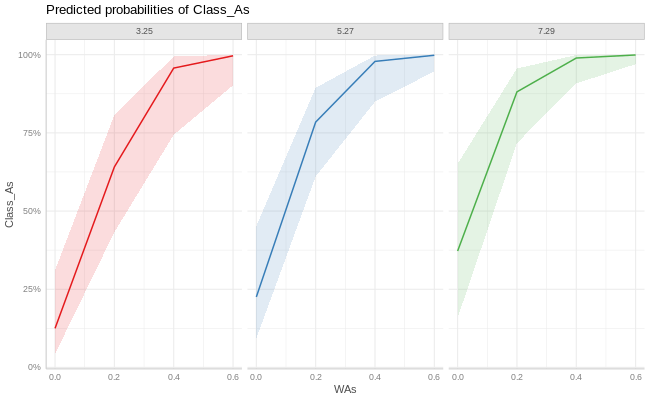

In [ ]:
%%R -w 650 -h 400 -u px
was.wfe <- predict_response(fit.logit, terms = c("WAs", "WFe"))
plot(was.wfe, facets = TRUE)

In [ ]:
%%R
was.year.wfe<- predict_response(fit.logit, terms = c("WAs", "Year_Irrigation", "WFe"))
was.year.wfe

  plots.



# Predicted probabilities of Class_As

Year_Irrigation: 2.7
WFe: 3.25

 WAs | Predicted |     95% CI
-----------------------------
0.00 |      0.04 | 0.01, 0.13
0.20 |      0.32 | 0.16, 0.54
0.40 |      0.86 | 0.45, 0.98
0.60 |      0.99 | 0.73, 1.00

Year_Irrigation: 2.7
WFe: 5.27

 WAs | Predicted |     95% CI
-----------------------------
0.00 |      0.07 | 0.02, 0.21
0.20 |      0.49 | 0.30, 0.69
0.40 |      0.92 | 0.62, 0.99
0.60 |      0.99 | 0.84, 1.00

Year_Irrigation: 2.7
WFe: 7.29

 WAs | Predicted |     95% CI
-----------------------------
0.00 |      0.14 | 0.04, 0.36
0.20 |      0.66 | 0.42, 0.84
0.40 |      0.96 | 0.75, 1.00
0.60 |      1.00 | 0.91, 1.00

Year_Irrigation: 7.2
WFe: 3.25

 WAs | Predicted |     95% CI
-----------------------------
0.00 |      0.13 | 0.04, 0.31
0.20 |      0.64 | 0.43, 0.81
0.40 |      0.96 | 0.74, 0.99
0.60 |      1.00 | 0.90, 1.00

Year_Irrigation: 7.2
WFe: 5.27

 WAs | Predicted |     95% CI
-----------------------------
0.00 |      0.23 

`geom_smooth()` using formula = 'y ~ x'


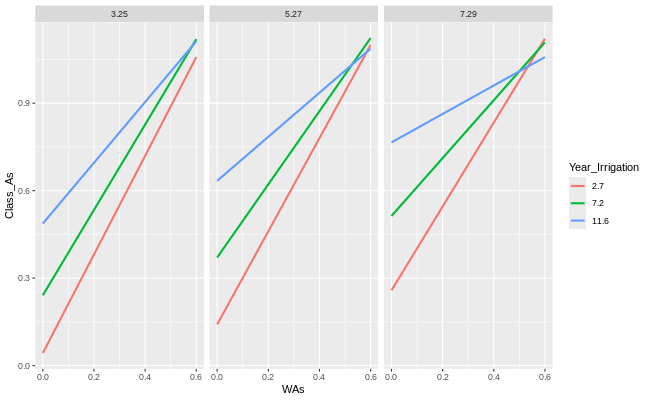

In [ ]:
%%R -w 650 -h 400 -u px
# select specific levels for grouping terms
ggplot(was.year.wfe, aes(x = x, y = predicted, colour = group)) +
  stat_smooth(method = "lm", se = FALSE) +
  facet_wrap(~facet) +
  labs(
    y = get_y_title(was.year.wfe),
    x = get_x_title(was.year.wfe),
    colour = get_legend_title(was.year.wfe)
  )

`effect_plot()` function of **jtools** package plot simple effects in logitic regression models:

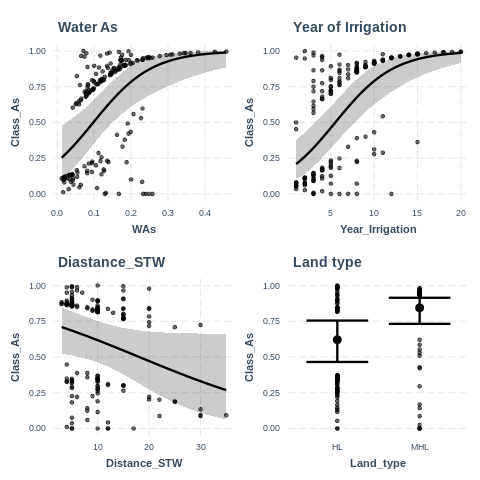

In [ ]:
%%R
p1<-jtools::effect_plot(fit.logit,
                    main.title = "Water As",
                    pred = WAs,
                    interval = TRUE,
                    partial.residuals = TRUE)
p2<-jtools::effect_plot(fit.logit,
                    main.title = "Year of Irrigation ",
                    pred = Year_Irrigation,
                    interval = TRUE,
                    partial.residuals = TRUE)
p3<-jtools::effect_plot(fit.logit,
                    main.title = "Diastance_STW",
                    pred = Distance_STW ,
                    interval = TRUE,
                    partial.residuals = TRUE)
p4<-jtools::effect_plot(fit.logit,
                    main.title = "Land type",
                    pred = Land_type,
                    interval = TRUE,
                    partial.residuals = TRUE)
library(patchwork)
(p1+p2)/(p3 +p4)

### Cross-validation



#### k-fold cross-validation

The {boot} package’s `cv.glm()` function provides an easy way to do `k-fold cross-validation` on GLM models. Here first we fit GLM model for entire dataset then we apply `cv.glm()` on fitted glm object.

In [ ]:
%%R
## Define cost function (for misclassification error)
cost <- function(r, pi) {
  # Convert predicted probabilities to binary predictions
  predictions <- ifelse(pi > 0.5, 1, 0)
  # Calculate the misclassification error
  mean(predictions != r)
}

fit.logit.mf<-glm(Class_As~., data= mf,
             family = binomial(link = "logit"))
cv_result <- cv.glm(data = mf, glmfit = fit.logit.mf, K = 5, cost = cost)

# Print cross-validation error
print(cv_result$delta)

[1] 0.05323194 0.04259133


However, this `cv.glm()` function does not directly provide predicted classes for each observation in the test folds; it only provides the `cross-validated error` estimates. However, we can achieve this by manually implementing k-fold cross-validation and storing the predictions for each fold.

In [ ]:
%%R
# Custom cross-validation function to get predicted classes
cross_validation_glm_predictions <- function(formula, data, k = 5, family = binomial, seed = 123) {
  set.seed(seed)

  n <- nrow(data)
  folds <- sample(rep(1:k, length.out = n))

  # Initialize a vector to store predicted probabilities
  all_probabilities <- numeric(n)

  for (i in 1:k) {
    train_data <- data[folds != i, ]
    test_data <- data[folds == i, ]

    # Fit GLM model
    model <- glm(formula = formula, data = train_data, family = family)

    # Predict probabilities for the test set
    test_probabilities <- predict(model, newdata = test_data, type = "response")

    # Store probabilities in the correct positions
    all_probabilities[folds == i] <- test_probabilities
  }

  return(all_probabilities)
}

# cress-validation
predicted_prob <- cross_validation_glm_predictions(
  formula = Class_As ~ WAs + WFe +  SAoFe + SOC + Year_Irrigation + Distance_STW + Land_type,
  data = mf,
  k = 5,
  family = binomial
)


#### Cross-validation Performance

In [ ]:
%%R
## predicted class
predicted_classes<-ifelse(predicted_prob  > 0.5, 1 ,0)
# actual class
actual_classes<-ifelse(mf$Class_As=="Yes", 1, 0)
# Calculate True Positives, False Positives, True Negatives, False Negatives
TP <- sum(actual_classes == 1 & predicted_classes == 1)
FP <- sum(actual_classes == 0 & predicted_classes == 1)
TN <- sum(actual_classes == 0 & predicted_classes == 0)
FN <- sum(actual_classes == 1 & predicted_classes == 0)

# Calculate Accuracy
accuracy <- (TP + TN) / (TP + FP + TN + FN)

# Calculate Precision
precision <- TP / (TP + FP)

# Calculate Recall
recall <- TP / (TP + FN)

# Calculate F1 Score
f1_score <- 2 * (precision * recall) / (precision + recall)

# Display results
cat("Accuracy:", accuracy, "\n")
cat("Precision:", precision, "\n")
cat("Recall:", recall, "\n")
cat("F1 Score:", f1_score, "\n")

Accuracy: 0.7984791 
Precision: 0.8232044 
Recall: 0.8764706 
F1 Score: 0.8490028 


#### ROC Curve

The ROC analysis can easily be performed using `roc()` function of {pROC} package.

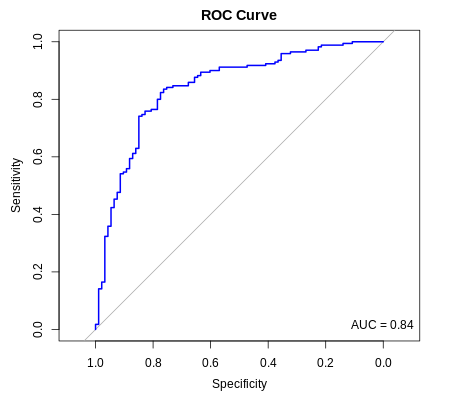

In [ ]:
%%R -w 450 -h 400 -u px

# compute ROC
roc_curve <- roc(actual_classes, predicted_prob )

# Plot the ROC curve
plot(roc_curve, main = "ROC Curve", col = "blue", lwd = 2)

# Add AUC to the plot
auc_value <- auc(roc_curve)
legend("bottomright", legend = paste("AUC =", round(auc_value, 2)), bty = "n")

### Prediction at test locations

The `predict()` function for logistic models returns the default predictions of log-odds, which are probabilities on the logit scale. When type = `response`, the function provides the predicted probabilities.



In [ ]:
%%R
test$Pred_prob<-predict(fit.logit, test, type = "response")
# setting the cut-off probability
test$Pred_Class<- ifelse(test$Pred_prob > 0.5,"Yes","No")

In [ ]:
%%R
ggpredict(fit.logit, terms = "WAs[0:0.50 by = 0.05]")

# Predicted probabilities of Class_As

 WAs | Predicted |     95% CI
-----------------------------
0.00 |      0.23 | 0.09, 0.45
0.05 |      0.35 | 0.20, 0.55
0.15 |      0.66 | 0.50, 0.79
0.20 |      0.78 | 0.61, 0.89
0.25 |      0.87 | 0.69, 0.95
0.30 |      0.93 | 0.76, 0.98
0.35 |      0.96 | 0.81, 0.99
0.50 |      0.99 | 0.91, 1.00

Adjusted for:
*             WFe =    5.27
*           SAoFe = 2576.72
*             SOC =    1.35
* Year_Irrigation =    7.19
*    Distance_STW =    9.77
*       Land_type =      HL


Not all rows are shown in the output. Use `print(..., n = Inf)` to show
  all rows.



#### Confusion Matrix at 50% Cut-Off Probability

Now, we classified an sites in the test data set with a probability of As contamination is greater than 0.5, as `Yes`, otherwise `No`.




In [ ]:
%%R
# Confusion matrix, proportion of cases
confusion_matrix = table(Actual = test$Class_As, Predicted =test$Pred_Class)
confusion_matrix

      Predicted
Actual No Yes
   No  17  11
   Yes  9  43




#### Prediction Performance

In [ ]:
%%R
# define variables
    TP <- confusion_matrix[2, 2]
    TN <- confusion_matrix[1, 1]
    FP <- confusion_matrix[2, 1]
    FN <- confusion_matrix[1, 2]

    # accuracy
    accuracy <- (TP + TN) / sum(confusion_matrix)

    # precision
    precision <- TP / (TP + FP)

    # Recall
    recall <- TP / (TP + FN)

    # specificity
    specificity <- TN / (TN + FP)

    # f1_score
    f1_score <- 2 * (precision * recall) / (precision + recall)

    # Print the results
    cat("Accuracy:", accuracy, "\n")
    cat("Precision:", precision, "\n")
    cat("Recall:", recall, "\n")
    cat("Specificity:", specificity, "\n")
    cat("F1 Score:", f1_score, "\n")

Accuracy: 0.75 
Precision: 0.8269231 
Recall: 0.7962963 
Specificity: 0.6538462 
F1 Score: 0.8113208 


#### ROC Curve


The ROC analysis can be easily performed using `roc()` of {pROC} package.

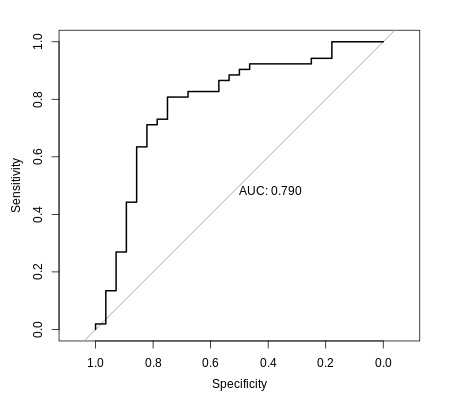

In [ ]:
%%R -w 450 -h 400 -u px
# Compute roc
res.roc <- pROC::roc(test$Class_As, test$Pred_prob)
plot.roc(res.roc, print.auc = TRUE)

On a graph, the gray diagonal line represents a classifier's performance that is no better than random chance. In contrast, a high-performing classifier will exhibit a ROC curve that rises steeply towards the top-left corner. This indicates that it can correctly identify a large number of positives without misclassifying many negatives. The AUC metric is commonly used to evaluate the performance of a classifier. An AUC value close to 1, which is the maximum possible value, is indicative of a highly effective classifier. In this case, our classifier exhibits an AUC value of 0.79, suggesting that it is indeed good. By contrast, a classifier that performs no better than random chance would have an AUC value of 0.5 when assessed using an independent test set that was not used for training the model.

In [ ]:
%%R
# Extract some interesting results
roc.data <-tibble(
  thresholds = res.roc$thresholds,
  sensitivity = res.roc$sensitivities,
  specificity = res.roc$specificities
)
# Get the probability threshold for specificity = 0.5
roc.data  |>
  filter(specificity >= 0.5)

# A tibble: 62 × 3
   thresholds sensitivity specificity
        <dbl>       <dbl>       <dbl>
 1      0.333       0.904       0.5  
 2      0.364       0.885       0.5  
 3      0.374       0.885       0.536
 4      0.391       0.865       0.536
 5      0.405       0.865       0.571
 6      0.416       0.846       0.571
 7      0.437       0.827       0.571
 8      0.478       0.827       0.607
 9      0.513       0.827       0.643
10      0.524       0.827       0.679
# ℹ 52 more rows
# ℹ Use `print(n = ...)` to see more rows


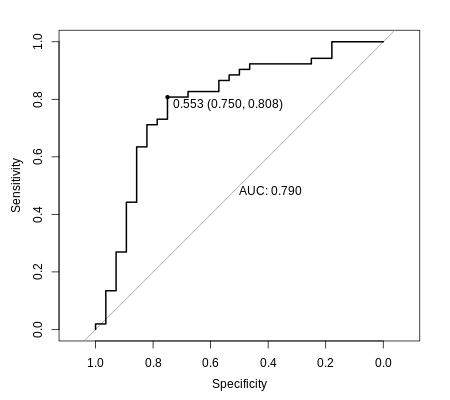

In [ ]:
%%R -w 450 -h 400 -u px
plot.roc(res.roc, print.auc = TRUE, print.thres = "best")

In [ ]:
%%R
rm(list=ls())

## Summary and Conclusion

This tutorial explains how to apply logistic regression to perform binary classification in R. It covers data preparation, model fitting, evaluation, and interpretation of results. It also provides insights into interpreting the coefficients of the logistic regression model and discusses potential challenges. By following this tutorial, readers can gain a solid understanding of logistic regression analysis in R.

Using logistic regression in R, researchers and data analysts can make informed decisions, identify important factors influencing binary outcomes, and gain insights into the relationships between predictors and outcome probabilities.


## References

1.  [How to Perform Logistic Regression in R](https://www.statology.org/logistic-regression-in-r/)

2.  [Evaluation of Classification Model Accuracy: Essentials](http://www.sthda.com/english/articles/36-classification-methods-essentials/143-evaluation-of-classification-model-accuracy-essentials/)

3.  [Precision, Recall and F1-Score using R](https://www.geeksforgeeks.org/precision-recall-and-f1-score-using-r/)

4.  [Chapter 6 Binary Logistic Regression](https://www.bookdown.org/rwnahhas/RMPH/blr.html)

5.  [Chapter 10 Binary Logistic Regression](https://bookdown.org/chua/ber642_advanced_regression/binary-logistic-regression.html)

6.  R Online Manual: [glm](http://stat.ethz.ch/R-manual/R-patched/library/stats/html/glm.html)

7.  [Applied Logistic Regression (Second Edition)](https://stats.oarc.ucla.edu/examples/alr2/) by David Hosmer and Stanley Lemeshow

8.  [Stat Books for Loan, Logistic Regression and Limited Dependent Variables](https://stats.oarc.ucla.edu/books/#Logistic%20Regression%20and%20Related%20Methods)



